In [31]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from macrocosm_visual.viz_setup import setup_matplotlib

setup_matplotlib()

## JAX - a small primer
This is a minimal (even less-than-minimal) introduction to JAX. We will cover some of the very basic features of the library.
However, there is **much much more** to learn about JAX! A good place to start is the [JAX documentation](https://docs.jax.dev/en/latest/notebooks/thinking_in_jax.html).

[0.         0.2018485  0.40266907 0.6014441  0.79717696]


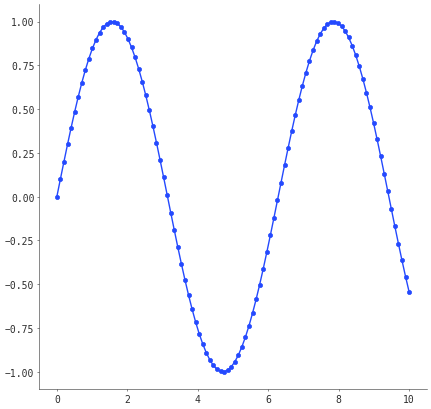

In [26]:
# Mostly, you can treat it like numpy

x = jnp.linspace(0, 10, 100)
y = jnp.sin(x)

# E.g., you can do all the usual numpy stuff
print((x + y)[:5])

# but also all the usual matplotlib stuff
fig, ax = plt.subplots(figsize=(10, 10), dpi=50)
ax.plot(x, y, "-o", label="Data")
plt.show()

In [23]:
# ... but actually there are a few differences.
import time

# Create some data
x = jnp.ones((5000, 5000))

# This returns immediately - computation is dispatched but not waited on
start = time.time()
y = jnp.dot(x, x)  # Large matrix multiply
print(f"After dot: {time.time() - start:.4f}s")  # Nearly instant

# This forces the computation to complete (blocking)
start = time.time()
y.block_until_ready()  # Or: float(y[0,0]), print(y), etc.
print(f"After block_until_ready: {time.time() - start:.4f}s")  # Actual compute time

# Key points:

# 1. Dispatching is async - jnp.dot() returns a "future" immediately while computation happens in the background
# 2. Some operations force synchronization (that is *actual* computation):
# - .block_until_ready() - explicit wait
# - Converting to Python scalar (float(), int())
# - Printing the array
# - Transferring to CPU/NumPy (.to_py(), np.array())
# - Using the value in Python control flow
# 3. Why it matters: This lets JAX overlap computation with Python overhead and queue multiple operations efficiently on accelerators
# (GPU/TPU).

After dot: 0.0001s
After block_until_ready: 0.4150s


In [24]:
# Jax builds a computation graph of the operations you do.


def simple_function(x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
    return x**2 + y


z = simple_function(x, y)

# We use jax.make_jaxpr to inspect the computation graph
jax.make_jaxpr(simple_function)(x, y)

{ lambda ; a:f32[5000,5000] b:f32[5000,5000]. let
    c:f32[5000,5000] = integer_pow[y=2] a
    d:f32[5000,5000] = add c b
  in (d,) }

In [30]:
# Jax can compute the gradient of the function
# The gradient of our function is [df / dx, df / dy] = (2x, 1). If we evaluate at x=1, y=2, we get (2, 1).

x = jnp.array(1.0, dtype=jnp.float32)
y = jnp.array(2.0, dtype=jnp.float32)

print(jax.grad(simple_function, argnums=(0, 1))(x, y))

# Let's inspect the computation graph of the gradient
jax.make_jaxpr(jax.grad(simple_function, argnums=(0, 1)))(x, y)

(Array(2., dtype=float32), Array(1., dtype=float32))


{ lambda ; a:f32[] b:f32[]. let
    c:f32[] = integer_pow[y=2] a
    d:f32[] = integer_pow[y=1] a
    e:f32[] = mul 2.0:f32[] d
    _:f32[] = add c b
    f:f32[] = mul 1.0:f32[] e
  in (f, 1.0:f32[]) }

In [35]:
# Key concepts:
# - By default JAX executes operations one at a time, in sequence.
# - Using a just-in-time (JIT) compilation decorator, sequences of operations can be optimized together and run at once.
# - Not all JAX code can be JIT compiled, as it requires array shapes to be static & known at compile time.
# All JAX operations are expressed in terms of XLA. If we have a sequence of operations,
# we can use the jax.jit function to compile this sequence of operations together using the XLA compiler.
from jax import jit


def norm(X):
    X = X - X.mean(0)
    return X / X.std(0)


norm_jit = jit(norm)

# The two functions are identical
np.random.seed(1701)
X = jnp.array(np.random.rand(10000, 10))
are_equal = np.allclose(norm(X), norm_jit(X), atol=1e-6)
print("Are the two functions equal?", are_equal)

# But due to the compilation (which includes fusing of operations, avoidance of allocating temporary arrays,
# and a host of other tricks), execution times can be orders of magnitude faster in the JIT-compiled case.
# We can use IPython’s %timeit to quickly benchmark our function, using block_until_ready()
# to account for JAX’s asynchronous dispatch

%timeit norm(X).block_until_ready()
%timeit norm_jit(X).block_until_ready()

Are the two functions equal? True
129 μs ± 724 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
121 μs ± 1.45 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [36]:
# Another useful transformation is jax.vmap, the vectorizing map.It has the familiar semantics of mapping
# a function along array axes, but instead of explicitly looping over function calls, it transforms
# the function into a natively vectorized version for better performance.
# When composed with jax.jit, it can be just as performant as manually rewriting your function to operate over an extra batch dimension.

key = jax.random.key(1701)
key1, key2 = jax.random.split(key)
mat = jax.random.normal(key1, (150, 100))
batched_x = jax.random.normal(key2, (10, 100))


def apply_matrix(x):
    return jnp.dot(mat, x)


def naively_batched_apply_matrix(v_batched):
    return jnp.stack([apply_matrix(v) for v in v_batched])


print("Naively batched")
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
217 μs ± 11.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [37]:
@jit
def batched_apply_matrix(batched_x):
    return jnp.dot(batched_x, mat.T)


np.testing.assert_allclose(
    naively_batched_apply_matrix(batched_x),
    batched_apply_matrix(batched_x),
    atol=1e-4,
    rtol=1e-4,
)
print("Manually batched")
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually batched
18.8 μs ± 619 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [38]:
# As functions become more complicated, this kind of manual batching becomes more difficult and error-prone.
# The jax.vmap transformation is designed to automatically transform a function into a batch-aware version:
@jit
def vmap_batched_apply_matrix(batched_x):
    return jax.vmap(apply_matrix)(batched_x)


np.testing.assert_allclose(
    naively_batched_apply_matrix(batched_x),
    vmap_batched_apply_matrix(batched_x),
    atol=1e-4,
    rtol=1e-4,
)
print("Auto-vectorized with vmap")
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
23 μs ± 333 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
# Vmap is great, e.g., to avoid for loops
def f(x):
    return x**2 + 1


# Without vmap
[jnp.sum(f(jnp.arange(1000))) for _ in range(1000)]

# With vmap
batched_f = jax.vmap(f)

xs = jnp.arange(1000)
batched_f(xs)

# Perfect for Monte Carlo simulations, repeated integrals,
# ensemble modeling, molecular dynamics, etc.

In [ ]:
# A different way of writing loops is to use lax.scan.

In [ ]:
# Also, code with JAX must be written in a functional style.
# In short, this means that:
# 1 - you should never mutate arrays. Instead, you should always create new arrays.
x = jnp.arange(10)
try:
    x[0] = 100
except Exception as e:
    print("This triggered an error!")
    print(e)

# Jax provides an indexed update syntax that returns an updated COPY of the array.
y = x.at[0].set(100)

# 2 - Functions depend ONLY on their arguments.
a = 1


def foo(x):
    # This is bad!
    return x + a


def bar(x, a):
    # This is good!
    return x + a